In [28]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.nn.functional as F
import itertools
from torch import Tensor
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

In [29]:
# train the model
def train_model(train_dl, model, test_dl, gpu_mode, draw_plt, device):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
    # enumerate epochs
    performance = []
    for _ in tqdm(range(300)):
        if draw_plt:
            model.train()
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            if gpu_mode:
              inputs = inputs.to(device)
              targets = targets.to(device)
            targets_one_hot = F.one_hot(targets, num_classes=6)

            targets_one_hot = targets_one_hot.view(-1, 6).to(torch.float)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            pred = model(inputs)
            pred = pred.view(-1, 6)

            # calculate loss
            loss = criterion(pred, targets_one_hot)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        
        if draw_plt:
            model.eval()
            performance.append(evaluate_model(test_dl, model, gpu_mode))

    return performance

# evaluate the model
def evaluate_model(test_dl, model, gpu_mode, device):
    predictions, actuals = [], []
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        if gpu_mode:
          inputs = inputs.to(device)
          targets = targets.to(device)
        yhat = model(inputs)
        # retrieve numpy array     
        actual = targets.cpu().numpy()
        actual = actual.reshape((-1, 1))
        # round to class values
        yhat = torch.argmax(yhat, dim=1).cpu().numpy()
        yhat = yhat.reshape((-1, 1))
        predictions.append(yhat)
        actuals.append(actual)
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    return accuracy_score(actuals, predictions)   
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    pred = model(row)
    # retrieve numpy array
    pred = np.argmax(pred.detach().numpy())
    return pred

In [30]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train_X, train_y):
        self.X = torch.from_numpy(train_X)
        self.labels = torch.from_numpy(train_y.astype(int)).view(-1, 1) - 1

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.labels[index]
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(48 * 48 * 3, 4096)
        self.output_layer = nn.Linear(4096, 6)

    def forward(self, x):
        x = x.view(-1, 48 * 48 * 3)
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        x = torch.softmax(x, dim=1)
        return x

In [31]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 13 * 13, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        x = torch.softmax(x, dim=1)
        return x

In [32]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

def plot_confusion_matrix(predictions, actuals):
    class_name=[0, 1, 2, 3, 4, 5]
    cnf_matrix = confusion_matrix(actuals, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_name, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_name, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [33]:
def print_report(acc, actuals, predictions):
    print('Accuracy: %s' % acc)
    print()
    plot_confusion_matrix(predictions, actuals)
    print()
    print('Confusion Matrix:')
    print(confusion_matrix(actuals, predictions))
    print()
    print('Classification Report:')
    print(classification_report(actuals, predictions, zero_division=1))

def evaluate_report(test_dl, model, gpu_mode, device):
    predictions, actuals = [], []
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        if gpu_mode:
          inputs = inputs.to(device)
          targets = targets.to(device)
        yhat = model(inputs)
        # retrieve numpy array
        
        actual = targets.cpu().numpy()
        actual = actual.reshape((-1, 1))
        # round to class values
        yhat = torch.argmax(yhat, dim=1).cpu().numpy()
        yhat = yhat.reshape((-1, 1))

        predictions.append(yhat)
        actuals.append(actual)

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    acc = accuracy_score(actuals, predictions) 

    print_report(acc, actuals, predictions)




In [34]:
is_colab = False
draw_plt = True
gpu_mode = True

batch_size = 64

if torch.cuda.is_available(): 
    dev = "cuda" 
else: 
    dev = "cpu"
device = torch.device(dev)

In [35]:
part = 'part1'
dataset_path = os.path.join('datasets', part)
if is_colab:
    dataset_path = os.path.join('/content/drive/MyDrive/AI_hw/hw1', dataset_path)
    
train_X_path  = os.path.join(dataset_path, 'train_X.npy')
train_y_path  = os.path.join(dataset_path, 'train_y.npy')
test_X_path = os.path.join(dataset_path, 'test_X.npy')
test_X_path = os.path.join(dataset_path, 'test_y.npy')

train_X = np.load(os.path.join(dataset_path, 'train_X.npy'))
train_y = np.load(os.path.join(dataset_path, 'train_y.npy'))
test_X = np.load(os.path.join(dataset_path, 'test_X.npy'))
test_y = np.load(os.path.join(dataset_path, 'test_y.npy'))


In [36]:
train_dataset = Dataset(train_X, train_y)
test_dataset = Dataset(test_X, test_y)

  0%|          | 0/300 [00:00<?, ?it/s]

tensor([[0],
        [1],
        [0],
        [2],
        [2],
        [0],
        [3],
        [1],
        [1],
        [0],
        [0],
        [4],
        [1],
        [5],
        [3],
        [5],
        [4],
        [4],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [3],
        [0],
        [4],
        [3],
        [2],
        [0],
        [4],
        [2],
        [0],
        [4],
        [0],
        [4],
        [5],
        [0],
        [2],
        [3],
        [3],
        [4],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [2],
        [1],
        [0],
        [3],
        [0],
        [1],
        [1],
        [1],
        [4],
        [0],
        [0],
        [1],
        [2],
        [0],
        [4],
        [2]], device='cuda:0', dtype=torch.int32)


RuntimeError: one_hot is only applicable to index tensor.

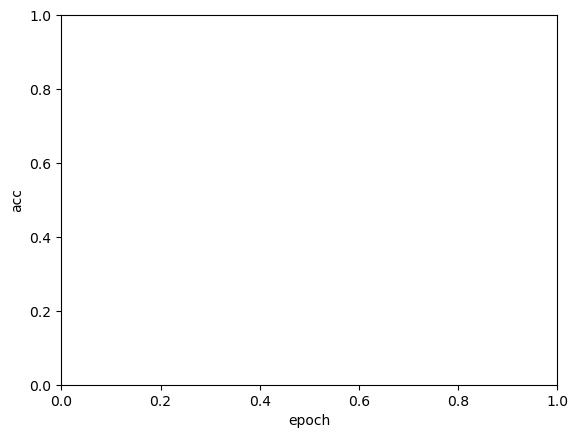

In [37]:
train_indices = list(range(len(train_X)))
test_indices = list(range(len(test_X)))

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_subsampler)

CNN = CNN()
MLP = MLP()
models = [(MLP, 'MLP'), (CNN, 'CNN')]
plt.cla()
plt.xlabel('epoch')
plt.ylabel('acc')
for model, model_name in models:
    if gpu_mode:
        model.to(device)
    performance_per_epoch = np.array(train_model(trainloader, model, testloader, gpu_mode, draw_plt, device))
    with torch.no_grad():
        acc = evaluate_report(testloader, model, gpu_mode, device)

    if draw_plt:
        plt.plot(performance_per_epoch, label = model_name)
        plt.legend(loc = 'lower right')
